This notebook derives certain elements of how conic locations and errors are estimated in mirrorfit based on 3D point locations and their associated errors.

The basic idea in every case is to find distances between measured points and the theoretical conic surface. This is done by projecting the point onto the conic, linearizing the conic at the projected point, and finding the distance between the point and the plane created by the linearization. 

In each case we assume we have been given a point ($X_0$, $Y_0$, $Z_0$) and associated errors ($\sigma_X$, $\sigma_Y$, $\sigma_Z$).

Below we derive results for two projection schemes, $Z$-projection and radial projection.

In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
sp.init_printing()

In [2]:
x,y,z,x0,y0,z0,sx0,sy0,sz0 = sp.symbols('x,y,z,X_{0} Y_{0} Z_{0} \sigma_{X_0} \sigma_{Y_0} \sigma_{Z_0}', real=True)

# $Z$-Projection

We start off with projecting our measured onto the conic along the $Z$-axis. This requires us to calculate the $Z$ coordinate from $X$ and $Y$. 

$conz$ will be our function for the $Z$ value of our conic evaluated at a distance $\rho=\sqrt{X^2+Y^2}$ from the origin on the $XY$-plane (we similarly define $\rho_0=\sqrt{X_0^2+Y_0^2}$). The symmetry of the conic allows us to use $\rho$ instead of $X$ and $Y$ individually.

We start off defining symbols we'll use to describe the conics as well as some assumptions we make about them:

In [3]:
k,R = sp.symbols('k R', real=True)
rho, rho0, srho0 = sp.symbols('\\rho \\rho_{0} \sigma_{\\rho_0}', real=True, positive=True)

In [4]:
c=1/R

$conz$ is our expression for the $z$ height of the conic.
$conconst$ is an expression that should be constant over the surface of the conic

In [5]:
conz = (c*rho**2) / (1 + sp.sqrt(1-(1+k)*c**2*rho**2))
conconst = conz-z

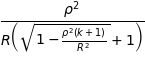

In [6]:
conz

We can now calculate $d_{Z_0}$, which we define as the $Z$ distance between our point and the conic, by evaluating $Z_0 - conz(\rho_0)$ but this distance overestimates the distance between the point and the conic. What we want to do in addition is linearize the conic at the $Z$ projection point and then calculate the distance to the plane representing this linearization. 

To linearize we need the gradient of the conic at our evaluation point, which is just $\frac{d conz}{d\rho}$ again because of symmetry, so the problem is effectively two dimensional:

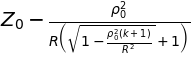

In [7]:
dz0 = z0-conz.subs(rho,rho0)
dz0

In [8]:
gradconz = sp.simplify(sp.diff(conz, rho))

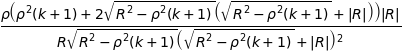

In [9]:
gradconz

To find our minimum distance $d_{min}$ to the linearized plane, we must find the length of the normal vector running from the plane to the point. 

To do this, we can imagine a triangle formed by the slope (gradient) we just calculated as $\frac{rise}{run}$ such that we have our "rise" of $gradconz(\rho)$ when our "run" is $1$. This triangle is geometrically similar to the triangle formed by the $Z$ projection distance from the point to the conic, the normal vector that runs from the linearized plane to the point (which is the minimum distance from the point to the plane), and the line connecting these two that runs along the linearized plane. This gives us a ratio equation involving $d_{min}$:

$$\frac{\sqrt{gradconz^2 + 1}}{1} = \frac{d_Z}{d_{min}},$$

yielding: 

$$d_{min} = \frac{d_Z}{\sqrt{gradconz^2+1}}.$$

We can think of this as a scale factor $S$ that we apply to $d_Z$:

$$S(\rho) = \frac{1}{\sqrt{gradconz(\rho)^2+1}},$$

such that finally:

$$d_{min}(\rho) = S(\rho) d_Z(\rho).$$


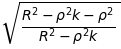

In [10]:
S = sp.symbols('S')
S=sp.simplify(sp.sqrt(sp.factor(sp.simplify(1 / (gradconz**2+1)))))
S

So we end up with the scale factor as:

$$S = \sqrt{\frac{R^2 - \rho^2(k+1)}{R^2-k\rho^2}}$$

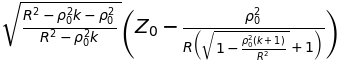

In [11]:
dmin0 = (S.subs(rho,rho0)*dz0)
dmin0

## Error Propagation

We want to calculate $\sigma_{d_{min}}$ using our point errors ($\sigma_{X_0}$,$\sigma_{Y_0}$,$\sigma_{Z_0}$). Since $X$ and $Y$ only enter through $\rho$ the first step we take is to calculate $\sigma_{\rho}$:

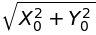

In [12]:
rho_ = sp.sqrt(x0**2+y0**2)
rho_

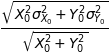

In [13]:
sr = sp.simplify(sp.sqrt(sp.diff(rho_,x0)**2*sx0**2 + sp.diff(rho_,y0)**2*sy0**2))
sr

So that $\sigma_{\rho_0}$ is sensibly:

$$\frac{\sqrt{X_0^2 \sigma_{X_0}^2 + Y_0^2 \sigma_{Y_0}^2}}{\rho_0}$$

Remebering that we want to compute $\sigma_{d_{min}}$ we can write:

$$\sigma_{d_{min}} = \Bigg( \bigg(\frac{\partial d_{min}}{\partial Z_0}\bigg)^2 \sigma_{Z_0}^2 + \bigg(\frac{\partial d_{min}}{\partial \rho_0} \bigg)^2 \sigma_{\rho_0}^2 \Bigg)^{\frac{1}{2}} $$

so we can look at the two derivatives individually, remembering that $d_{min}(\rho) = S(\rho) d_Z(\rho) = S(\rho) (Z_0 - conz(\rho))$.

It is clear that:

$$\frac{\partial d_{min}}{\partial Z_0} = S,$$

and that 

$$\frac{\partial d_{min}}{\partial \rho_0} = \frac{\partial S}{\partial \rho_0} d_{Z_0} - \frac{\partial conz}{\partial \rho_0} S.$$

We calculate $\frac{\partial S}{\partial \rho}$ as follows:



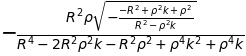

In [14]:
sp.simplify((sp.diff(S,rho)))

We get:
$$\frac{\partial S}{\partial \rho} = \frac{-\rho R^2S}{R^2(R^2-\rho^2(2k+1))+\rho^4k(k+1)},$$

which is ugly but tractable. $\frac{\partial conz}{\partial \rho}$ we have already calculated as "$gradconz$".

Collecting terms we get:

$$\sigma_{d_{min}} = \Bigg( S^2 \sigma_{Z_0}^2 + \bigg(\frac{\partial S}{\partial \rho_0} d_{Z_0} - (gradconz) S\bigg)^2 \sigma_{\rho_0}^2 \Bigg)^{\frac{1}{2}} $$

We define:

$$\gamma = \frac{\rho R^2}{R^2(R^2-\rho^2(2k+1))+\rho^4k(k+1)},$$

so that:

$$\sigma_{d_{min}} = S \Bigg( \sigma_{Z_0}^2 + \bigg(\gamma d_{Z_0} + (gradconz) \bigg)^2 \sigma_{\rho_0}^2 \Bigg)^{\frac{1}{2}} $$


A bit of numerical experimentation: 

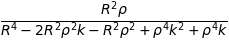

In [15]:
gamma = sp.simplify(-sp.simplify((sp.diff(S,rho)))/ S)
gamma

In [16]:
def numeric(val, Rval=440, kval=-1, rhoval=3.9, z0val=800):
    return sp.N(val.subs(R, Rval).subs(k,kval).subs(rho, rhoval).subs(z0,z0val))

In [17]:
def numeric2(val, Rval=440, kval=-1):
    return sp.N(val.subs(R, Rval).subs(k,kval))

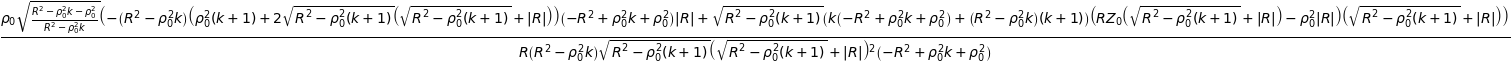

In [18]:
sp.simplify(sp.diff(dmin0, rho0))

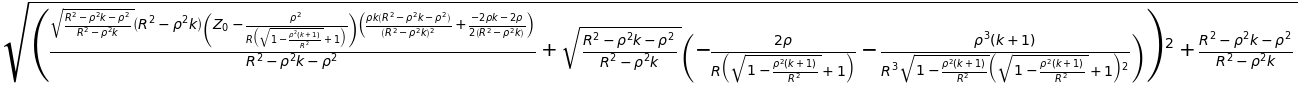

In [19]:
testval_full=sp.sqrt((sp.diff(dmin0, z0)**2 + sp.diff(dmin0, rho0)**2)).subs(rho0,rho)
testval_full

In [20]:
testval_simp = (S*sp.sqrt(1+(gamma*dz0+gradconz)**2)).subs(rho0,rho)

In [21]:
sp.collect(numeric(testval_full),rho), (sp.collect(numeric(testval_simp),rho))

# Radial projection

We now turn to another projection where the point is projected onto the conic via the line connecting the origin to the point. This projection will only work for $k\gt-1$ (i.e. only for ellipses). Whereas before our origin of the coordinate system was at the tip of our conic, it will now be in the center. 

We want to recast our variables $R$ and $k$ in terms of the ellipse axes: 
$$r_{xy} = -\frac{R}{k+1}$$

$$r_z = \sqrt{\frac{R^2}{k+1}}$$

We will assume a more general ellipsoid however, allowing for three distinct axes values $r_x$, $r_y$, and $r_z$.

In [22]:
rx,ry,rz = sp.symbols('r_{x} r_{y} r_{z}', real=True, positive=True)
x,y,z,dv = sp.symbols('x y z d', real=True)
dx,dy,dz = sp.symbols('\delta_x \delta_y \delta_z', real=True)
p0 = sp.Matrix([x0,y0,z0])

In [23]:
rsq = x0**2+y0**2 + z0**2
rsq

We first calculate the points of the ellipse along the line connecting the origin to our data point ($X_0$, $Y_0$, $Z_0$).

The equation of the ellipse is:

$$\frac{X^2}{r_x^2} + \frac{Y^2}{r_y^2} + \frac{Z^2}{r_z^2} = 1$$,

whereas in general if we insert $X_0$, $Y_0$, and $Z_0$ into this equation we well get some value $\ne$ 1 which we can call $\lambda$:
$$\frac{X_0^2}{r_x^2} + \frac{Y_0^2}{r_y^2} + \frac{Z_0^2}{r_z^2} = \lambda,$$
and we can define

$$s = \frac{1}{\sqrt{\lambda}}$$
such that:
$$\frac{(sX_0)^2}{r_x^2} + \frac{(sY_0)^2}{r_y^2} + \frac{(sZ_0)^2}{r_z^2} = 1.$$

$s$ multiplicatively rescales our $X_0$, $Y_0$, and $Z_0$ to give us a point on the conic $(cx_0, cy_0, cz_0)$:

$$(cx_0, cy_0, cz_0) = (sX_0, sY_0, sZ_0)$$

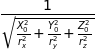

In [24]:
s = 1/sp.sqrt(x0**2/rx**2+y0**2/ry**2+z0**2/rz**2)
s

In [25]:
cx=s*x0
cy=s*y0
cz=s*z0
epoint = sp.Matrix([cx,cy,cz])
epoint

⎡             X_{0}              ⎤
⎢────────────────────────────────⎥
⎢      __________________________⎥
⎢     ╱      2        2        2 ⎥
⎢    ╱  X_{0}    Y_{0}    Z_{0}  ⎥
⎢   ╱   ────── + ────── + ────── ⎥
⎢  ╱         2        2        2 ⎥
⎢╲╱     r_{x}    r_{y}    r_{z}  ⎥
⎢                                ⎥
⎢             Y_{0}              ⎥
⎢────────────────────────────────⎥
⎢      __________________________⎥
⎢     ╱      2        2        2 ⎥
⎢    ╱  X_{0}    Y_{0}    Z_{0}  ⎥
⎢   ╱   ────── + ────── + ────── ⎥
⎢  ╱         2        2        2 ⎥
⎢╲╱     r_{x}    r_{y}    r_{z}  ⎥
⎢                                ⎥
⎢             Z_{0}              ⎥
⎢────────────────────────────────⎥
⎢      __________________________⎥
⎢     ╱      2        2        2 ⎥
⎢    ╱  X_{0}    Y_{0}    Z_{0}  ⎥
⎢   ╱   ────── + ────── + ────── ⎥
⎢  ╱         2        2        2 ⎥
⎣╲╱     r_{x}    r_{y}    r_{z}  ⎦

The equation for our ellipse is (e=1):

In [26]:
e=x**2/rx**2 + y**2/ry**2+z**2/rz**2

This expression is constant over the surface of the ellipse so that $\nabla e$ is parallel to the normal vector at each point and rescale to simplify:

In [35]:
egrad=sp.Matrix([sp.diff(e,x), sp.diff(e,y), sp.diff(e,z)])
egrad = ((egrad.subs(x,cx).subs(y,cy).subs(z,cz))/2)
egrad

⎡                 X_{0}                 ⎤
⎢───────────────────────────────────────⎥
⎢             __________________________⎥
⎢            ╱      2        2        2 ⎥
⎢     2     ╱  X_{0}    Y_{0}    Z_{0}  ⎥
⎢r_{x} ⋅   ╱   ────── + ────── + ────── ⎥
⎢         ╱         2        2        2 ⎥
⎢       ╲╱     r_{x}    r_{y}    r_{z}  ⎥
⎢                                       ⎥
⎢                 Y_{0}                 ⎥
⎢───────────────────────────────────────⎥
⎢             __________________________⎥
⎢            ╱      2        2        2 ⎥
⎢     2     ╱  X_{0}    Y_{0}    Z_{0}  ⎥
⎢r_{y} ⋅   ╱   ────── + ────── + ────── ⎥
⎢         ╱         2        2        2 ⎥
⎢       ╲╱     r_{x}    r_{y}    r_{z}  ⎥
⎢                                       ⎥
⎢                 Z_{0}                 ⎥
⎢───────────────────────────────────────⎥
⎢             __________________________⎥
⎢            ╱      2        2        2 ⎥
⎢     2     ╱  X_{0}    Y_{0}    Z_{0}  ⎥
⎢r_{z} ⋅   ╱   ────── + ────── + ─

We can then find an equation of a plane with form $ax + by + cz + d = 0$ that shares this normal vector and intersects our ellipse at $(cx, cy, cz)$. On the ellipse we know that $ax + by + cz=1$ so $d$ must be a constant. Quickly check the value:

In [37]:
d=sp.solve(egrad.dot(epoint)+dv,dv)[0]
d

In [38]:
egrad/egrad.norm()

⎡                                                                           X_
⎢─────────────────────────────────────────────────────────────────────────────
⎢             __________________________          ____________________________
⎢            ╱      2        2        2          ╱                    2       
⎢     2     ╱  X_{0}    Y_{0}    Z_{0}          ╱                X_{0}        
⎢r_{x} ⋅   ╱   ────── + ────── + ────── ⋅      ╱   ───────────────────────────
⎢         ╱         2        2        2       ╱           ⎛     2        2    
⎢       ╲╱     r_{x}    r_{y}    r_{z}       ╱          4 ⎜X_{0}    Y_{0}    Z
⎢                                           ╱      r_{x} ⋅⎜────── + ────── + ─
⎢                                          ╱              ⎜     2        2    
⎢                                        ╲╱               ⎝r_{x}    r_{y}    r
⎢                                                                             
⎢                                                   

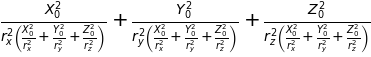

In [39]:
egrad.dot(epoint)

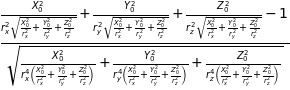

In [40]:
dmin=(egrad.dot(p0)+d)/egrad.norm()
dmin

In [41]:
n = sp.sqrt(x0**2/rx**2 + y0**2/ry**2 + z0**2/rz**2)

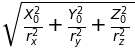

In [42]:
n

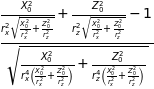

In [45]:
dmin.subs(ry,sp.oo)